### Environment setup


!pip install pandas numpy scikit-learn matplotlib seaborn

# Risk Segmentation (Unsupervised Learning)

1. Explore & clean the data.
2. Perform preprocessing .
3. Reduce dimensionality via PCA for visualization.
4. Apply clustering (K‑Means) to group similar applicants.
5. Profile clusters to infer potential credit‑risk segments.
6. Detect anomalies/outliers using Isolation Forest.

## 1. Setup & Data Load

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest



In [13]:
# Data Load
pd.set_option('display.max_columns', None)

DATA_PATH = 'german_credit_data.csv'
df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## 2. Quick Exploration & Cleaning

In [14]:
print(f'Dataset shape: {df.shape}')

print('Missing Data:\n', df.isna().sum()[df.isna().sum() > 0]) 
df.describe(include='all').T

Dataset shape: (1000, 10)
Missing Data:
 Saving accounts     183
Checking account    394
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,NaN,NaN,NaN,499.5,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# drop column 'unnamed: 0' as it is an index column
df.drop(columns=['Unnamed: 0'], inplace=True)
# drop missing values
#df.dropna(inplace=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [16]:
# Check
print(df.describe(include='all').T)
df.isna().sum()[df.isna().sum() > 0]  

                   count unique     top freq      mean          std    min  \
Age               1000.0    NaN     NaN  NaN    35.546    11.375469   19.0   
Sex                 1000      2    male  690       NaN          NaN    NaN   
Job               1000.0    NaN     NaN  NaN     1.904     0.653614    0.0   
Housing             1000      3     own  713       NaN          NaN    NaN   
Saving accounts      817      4  little  603       NaN          NaN    NaN   
Checking account     606      3  little  274       NaN          NaN    NaN   
Credit amount     1000.0    NaN     NaN  NaN  3271.258  2822.736876  250.0   
Duration          1000.0    NaN     NaN  NaN    20.903    12.058814    4.0   
Purpose             1000      8     car  337       NaN          NaN    NaN   

                     25%     50%      75%      max  
Age                 27.0    33.0     42.0     75.0  
Sex                  NaN     NaN      NaN      NaN  
Job                  2.0     2.0      2.0      3.0  
Housing

Saving accounts     183
Checking account    394
dtype: int64

### 2.1 Separate features by type

In [17]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
print('Categorical columns:', cat_cols)
print('Numerical columns  :', num_cols)

Categorical columns: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Numerical columns  : ['Age', 'Job', 'Credit amount', 'Duration']


## 3. Pre‑processing Pipeline

In [18]:
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe'    , OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

X_proc = preprocessor.fit_transform(df)
print('Processed feature matrix shape:', X_proc.shape)

Processed feature matrix shape: (1000, 24)


## 4. Dimensionality Reduction (PCA)

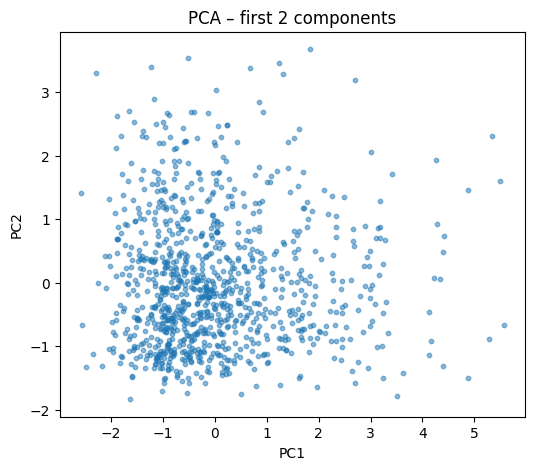

Explained variance (2 comps): 0.442


In [19]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_proc)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
plt.title('PCA – first 2 components'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()
print('Explained variance (2 comps):', pca.explained_variance_ratio_.sum().round(3))

## 5. Clustering – K‑Means

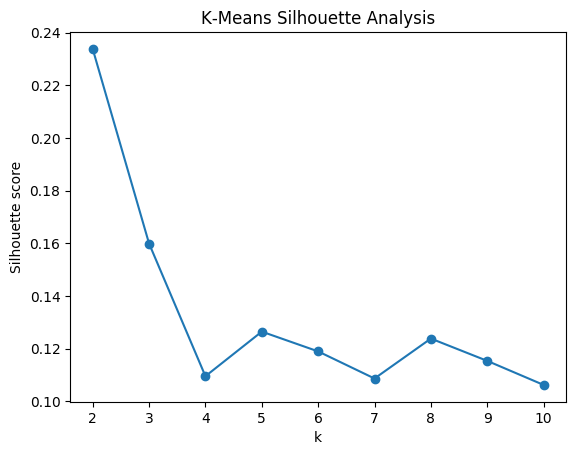

In [20]:
sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_proc)
    sil = silhouette_score(X_proc, labels)
    sil_scores[k] = sil

plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.title('K‑Means Silhouette Analysis'); plt.show()

Best k by silhouette: 2


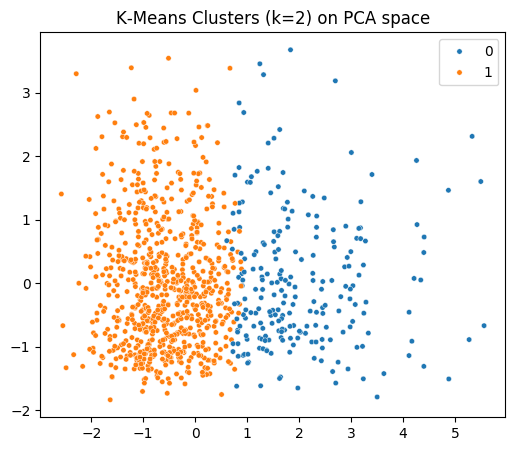

In [21]:
best_k = max(sil_scores, key=sil_scores.get)
print('Best k by silhouette:', best_k)
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_proc)
df['Cluster'] = clusters

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', s=15)
plt.title(f'K‑Means Clusters (k={best_k}) on PCA space'); plt.show()

### 5.1 Cluster Profiling

In [22]:
profile = df.groupby('Cluster').agg({col:['mean', 'median'] for col in num_cols})
profile.head()

Age              Job        Credit amount           Duration  \
              mean median      mean median          mean  median       mean   
Cluster                                                                       
0        36.692982   34.0  2.285088    2.0   7201.241228  6711.5  36.776316   
1        35.207254   33.0  1.791451    2.0   2110.589378  1859.0  16.215026   

                
        median  
Cluster         
0         36.0  
1         15.0